In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#const
dataset_dir = '/content/drive/MyDrive/dataset_wisata'
class_labels = os.listdir(dataset_dir)

In [ ]:
def clean_dataset(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            try:
                # Attempt to open the image file
                with Image.open(filepath) as img:
                    img.verify()  # Check if it's a valid image
            except (IOError, SyntaxError) as e:
                print(f"Removing invalid image: {filepath}")
                os.remove(filepath)  # Remove the invalid image

# Run the cleaning function on your dataset directory
clean_dataset(dataset_dir)

In [ ]:
# Define ImageDataGenerator for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3657 images belonging to 6 classes.
Found 912 images belonging to 6 classes.


In [ ]:
# Check how many images each class
class_counts = {}

# Loop through each class folder and count the images
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")


Class 'pemandian': 645 images
Class 'beach': 1000 images
Class 'buatan': 939 images
Class 'mountain': 717 images
Class 'waterfall': 735 images
Class 'nature': 533 images


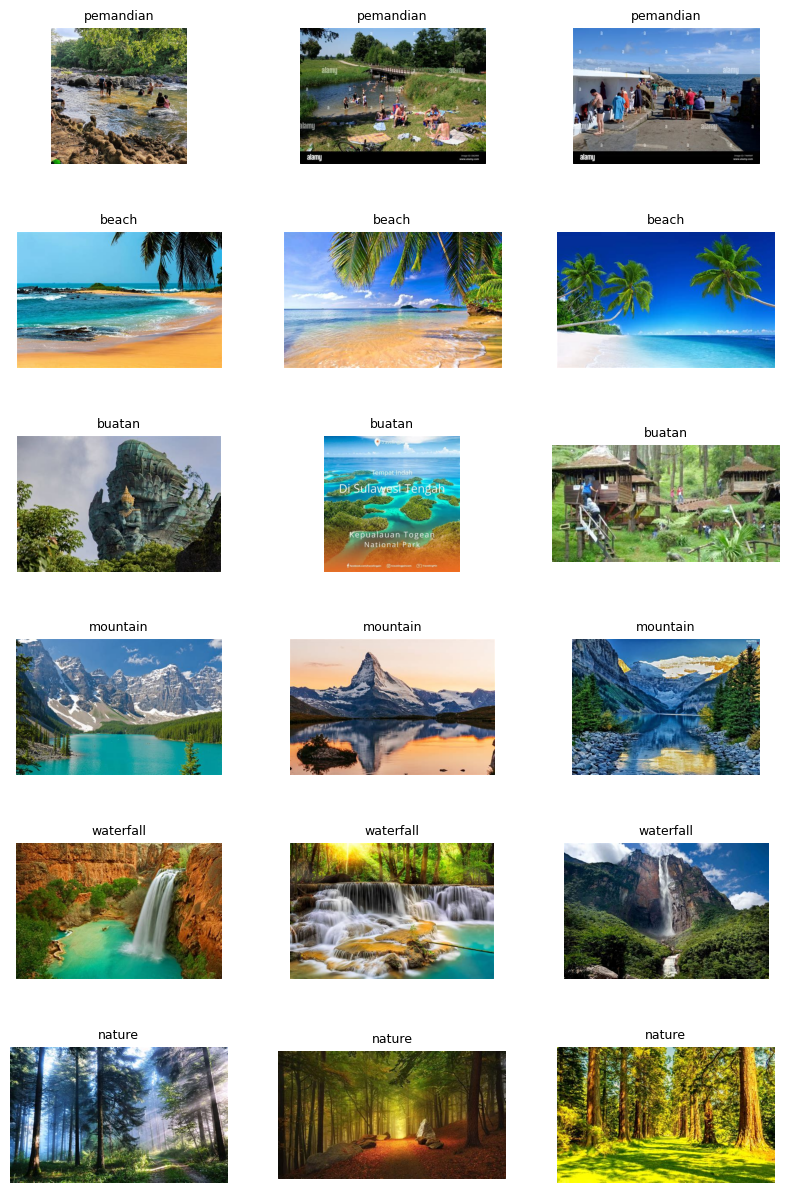

In [ ]:
images_per_class = 3
fig, axes = plt.subplots(len(class_labels), images_per_class, figsize=(10, len(class_labels) * 2.5))
fig.subplots_adjust(hspace=0.5)  # Adjust space between rows

for i, class_label in enumerate(class_labels):
    class_dir = os.path.join(dataset_dir, class_label)
    image_files = os.listdir(class_dir)[:images_per_class]  # Get some images from the class

    for j in range(images_per_class):
        img_path = os.path.join(class_dir, image_files[j])
        img = Image.open(img_path)

        # Display the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')  # Hide axes
        axes[i, j].set_title(class_label, fontsize=9)  # Set class label as title

# Show the image grid
plt.show()

In [ ]:
# Load MobileNetV2 with pre-trained weights and exclude the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(128, activation='relu')(x)  # Add a fully connected layer
output = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor the validation accuracy
    patience=3,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore the weights of the best epoch
)

epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 1442s 12s/step - accuracy: 0.5490 - loss: 1.2393 - val_accuracy: 0.7545 - val_loss: 0.7305
Epoch 2/20
  1/114 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.6562 - loss: 0.9300

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6562 - loss: 0.9300 - val_accuracy: 0.8125 - val_loss: 0.7172
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7229 - loss: 0.7975 - val_accuracy: 0.7310 - val_loss: 0.7700
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8125 - loss: 0.6820 - val_accuracy: 0.9375 - val_loss: 0.3859
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.7454 - loss: 0.7356 - val_accuracy: 0.7132 - val_loss: 0.8196
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 243ms/step - accuracy: 0.7500 - loss: 0.7877 - val_accuracy: 0.8750 - val_loss: 0.3772
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.7542 - loss: 0.7265 - val_accuracy: 0.7634 - val_loss: 0.6813


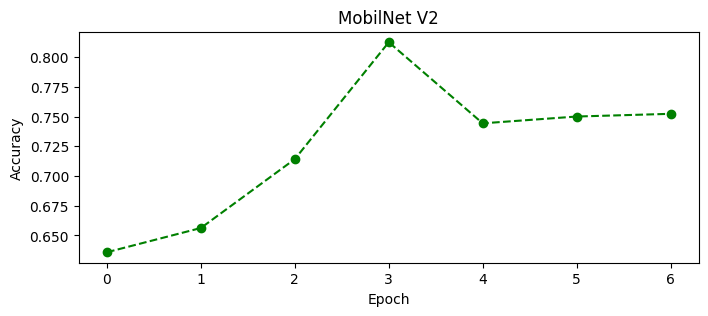

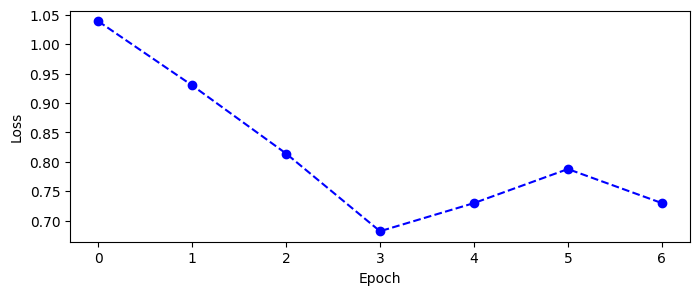

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(history.history['accuracy'], 'og', linestyle='dashed')
#ax.plot(history.history['val_accuracy'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
#ax.legend(['train', 'val'], loc='lower right')
plt.title("MobilNet V2")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(history.history['loss'], 'ob', linestyle='dashed')
#ax.plot(history.history['val_loss'])
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
#ax.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
import pandas as pd

model.save("/content/drive/MyDrive/Model Citra Wisata/model/mobileNet_v2.h5")

# 02 - Save model report to csv
model_csv = pd.DataFrame(history.history)
csv_file = "/content/drive/MyDrive/Model Citra Wisata/model/mobileNet_v2.csv"
with open(csv_file, mode="w") as f:
  model_csv.to_csv(f)

In [ ]:
import gc
if "model" in globals():
  del model
  gc.collect()

In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Model Citra Wisata/model/mobileNet_v2.h5')

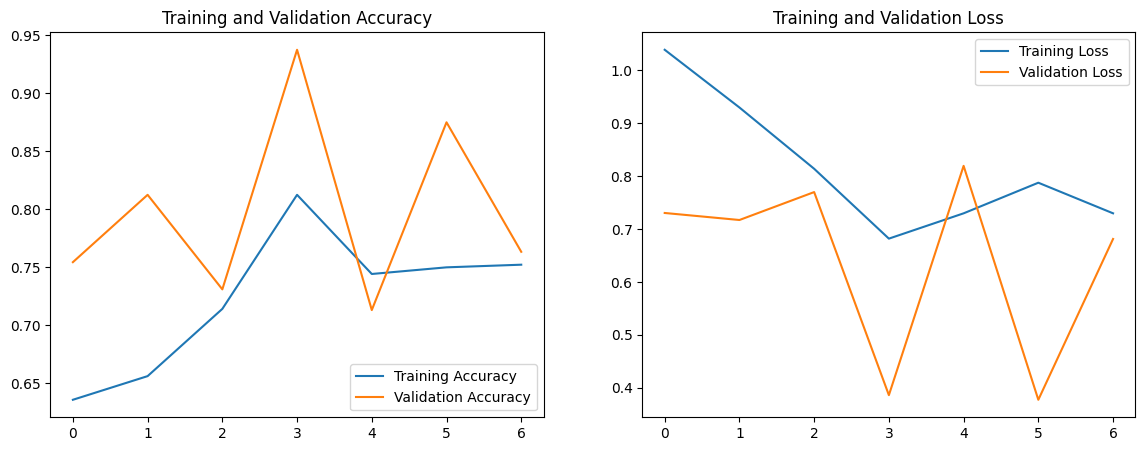

In [ ]:
# Plotting accuracy and loss
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Call the plotting function
plot_metrics(history)

In [ ]:
# Evaluate the model on the validation data
loss, acc = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {acc:.4f}")

# Make predictions using the validation generator
predictions = model.predict(validation_generator, verbose=1)

# Get the predicted class indices
predicted_labels = np.argmax(predictions, axis=-1)

# Get the true labels from the generator
true_labels = validation_generator.classes

# Class indices mapping (to understand the label encoding)
class_indices = validation_generator.class_indices
class_labels = list(class_indices.keys())

# Print the predicted and true labels for the first few samples
print("Predicted Labels:", predicted_labels[:10])
print("True Labels     :", true_labels[:10])

#Compare predictions with true labels
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7697 - loss: 0.6660
Validation Loss: 0.7197, Validation Accuracy: 0.7511
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step
Predicted Labels: [0 2 1 2 2 0 5 0 0 5]
True Labels     : [0 0 0 0 0 0 0 0 0 0]

Classification Report:
              precision    recall  f1-score   support

       beach       0.24      0.28      0.26       200
      buatan       0.24      0.26      0.25       187
    mountain       0.12      0.10      0.11       143
      nature       0.09      0.11      0.10       106
   pemandian       0.11      0.05      0.07       129
   waterfall       0.13      0.16      0.14       147

    accuracy                           0.18       912
   macro avg       0.16      0.16      0.16       912
weighted avg       0.17      0.18      0.17       912



29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step


<Figure size 1000x800 with 0 Axes>

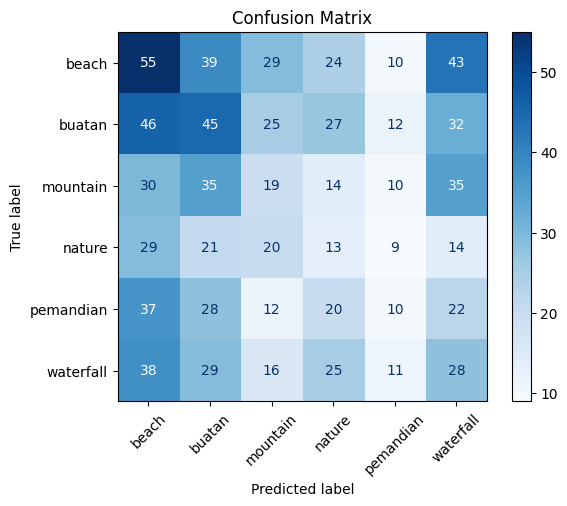

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get predictions and true labels
predictions = model.predict(validation_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=-1)  # Convert probabilities to predicted class indices
true_labels = validation_generator.classes           # True class indices from the generator

# Class labels for plotting
class_labels = list(validation_generator.class_indices.keys())

# Step 2: Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Ini buat handle inputan citra baru
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
img_size_224p = 224
# load and prepare the image
def load_image(filename):
    img = load_img(filename, target_size=(img_size_224p, img_size_224p))
    plt.imshow(img)
    plt.axis("off");
    img = img_to_array(img)
    img = img.reshape(-1, img_size_224p, img_size_224p, 3)
    img = img.astype('float32')
    img = img / 255.0
    return img

def run_example(new_data_path):
    # load the image
    img = load_image(new_data_path)
    # load model
    model = load_model('/content/drive/MyDrive/Model Citra Wisata/model/mobileNet_v2.h5')
    # predict the class probabilities
    result_probs = model.predict(img)
    # get the predicted class index
    result_index = np.argmax(result_probs)

    # map the index to class names
    class_names = ['Pantai', 'Wisata Buatan', 'Gunung', 'Alam', 'Pemandian', 'Air Terjun']
    predicted_class = class_names[result_index]

    print(f"\nHasil Prediksi: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Hasil Prediksi: Air Terjun


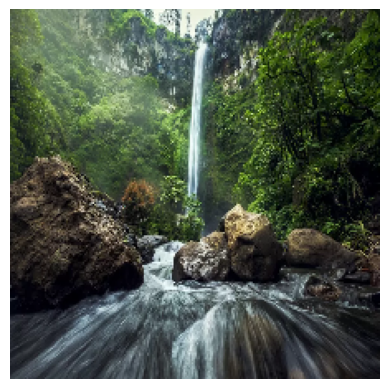

In [ ]:
new_data_path = '/content/drive/MyDrive/tesairterjun.png'
run_example(new_data_path)